In [1]:
import model
import numpy as np
import random
import tank
import truck


import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import utilsq as ut

import time

## System initializer

In [2]:
def initialize_test_system(seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 100., 200., 300., 400.])
    #tank_current_loads =  np.array([50., 60., 120., 150., 300.])
    #tank_current_loads = tank_max_loads.copy()
    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])

        
    for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
        a = np.linspace(0,max_load, lvl+1)[1]
        current_load = np.random.randint(a+1,max_load)
        tank_current_loads[i] = current_load  

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([20., 50.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    #w =  np.array([0, 20., 10., 30., 50.5, 45.])
    w =  np.array([20., 20., 20., 20., 20., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#print(toy_system.weights)

a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [3]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
#print([load for load in system.tank_loads])
print(system.graph)
print(system.weights)

[77, 40, 157, 147, 289]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 20.  20.  20.  20.  20.   0.]]


In [4]:
verbose = False
print(system.tank_loads())
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

system = reinitialize_system(system,3)
print(system.tank_loads())
system = reinitialize_system(system,4)
print(system.tank_loads())
reward = system.random_action(seed = 1, verbose = verbose)
system.reset_trucks_positions();
#print(reward)
reward = system.random_action(seed = 1, verbose = verbose)
#print(reward)

[77, 40, 157, 147, 289]
[50.0, 29.0, 51.0, 97.0, 248.0]
[72.0, 81.0, 180.0, 180.0, 188.0]


## Q-learning algorithm (off-policy)


### Training

In [5]:
# Train parameters:
retrain = False
train_epsilon = False

learning_rate0 = 0.05 #??
learning_rate_decay = 0.1 #??

episodes = 10**3 #episodes
train_freq = 10**2
episode_length = 50

discount_rate = 1

epsilon0 = 1.0
epsilon_decay = 1./episodes *10
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

simulation_id = 12

# if retrain == True:
#     simulation_id_retrain = 3
#     iteration_retrain = 50*10**6
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id_retrain}" + "-" + f"{iteration_retrain}")

ut.save_obj(toy_system, "system-sim"+f"{simulation_id}")

In [6]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            simulation_id = simulation_id,
            round_time = 2
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print("Episode ", episode, ", Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)

                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());    

                ut.save_obj(Q, "Q-dict-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                ut.save_obj(visualization_steps, "vis/vis-train-sim" + f"{simulation_id}" + "-" + f"{episode}")   
                #rewards_list.append(discounted_reward);
                ut.save_obj(rewards_list, "discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
   
    end_time = round(time.time()-time_start,round_time)        
    print(f"Training finished. Total episodes: {n_episodes}. Elapsed time: {round(end_time/60., round_time)} minuts.")        

In [7]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [8]:
if train_epsilon == True:
    #train_Q_epsilon()
    episodic_train_Q_epsilon()

### Testing

In [9]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

#Load trained Q-values
# if train == False:
#     simulation_id = 8
#     train_iterations = 20*10**5
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")


# if retrain == False:
#     simulation_id = 7
#     train_iterations = 259*10**6
#     test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
#     Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

   
#test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
if train_epsilon == False:
    simulation_id = 11
    episodes =200000
    
Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{episodes}")


test_episodes = 1
episode_length = 1000
test_freq = 1
test_verbose = True

test_visualization_steps = []
test_rewards_list = []

In [10]:
def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           freq = test_freq,
           test_verbose = test_verbose
           
          ):
    
    for episode in range(1,n_episodes+1): 
        reinitialize_system(system, seed = episode)

        discounted_reward = 0      
        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, reward, " Random action is performed. Current state unknown for Q.")

            else:
                reward = system.deterministic_action(best_action)
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,reward, best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);


In [11]:
test_Q()

Episode 1 t 0 -70.0 5200
Episode 1 t 1 -40.0 0500
Episode 1 t 2 -273.3 0500
Episode 1 t 3 -40.0 1500
Episode 1 t 4 0.0 5500
Episode 1 t 5 -40.0 4500
Episode 1 t 6 -110.0 4100
Episode 1 t 7 0.0 5500
Episode 1 t 8 0.0 5500
Episode 1 t 9 0.0 5500
Episode 1 t 10 0.0 5500
Episode 1 t 11 -110.0 3000
Episode 1 t 12 -40.0 4500
Episode 1 t 13 -40.0 4500
Episode 1 t 14 0.0 5500
Episode 1 t 15 -40.0 4500
Episode 1 t 16 -343.3 0300
Episode 1 t 17 -40.0 1500
Episode 1 t 18 -40.0 4500
Episode 1 t 19 -40.0 4500
Episode 1 t 20 -343.3 0300
Episode 1 t 21 -70.0 5100
Episode 1 t 22 -110.0 2300
Episode 1 t 23 0.0 5500
Episode 1 t 24 0.0 5500
Episode 1 t 25 0.0 5500
Episode 1 t 26 -40.0 2500
Episode 1 t 27 -40.0 2500
Episode 1 t 28 -40.0 2500
Episode 1 t 29 -110.0 3100
Episode 1 t 30 -70.0 5200
Episode 1 t 31 -40.0 1500
Episode 1 t 32 -70.0 5200
Episode 1 t 33 -70.0 5000
Episode 1 t 34 0.0 5500
Episode 1 t 35 0.0 5500
Episode 1 t 36 0.0 5500
Episode 1 t 37 0.0 5500
Episode 1 t 38 0.0 5500
Episode 1 t 39 -7

Episode 1 t 307 -506.6 2500
Episode 1 t 308 -110.0 0300
Episode 1 t 309 -40.0 2500
Episode 1 t 310 -273.3 2500
Episode 1 t 311 -110.0 1000
Episode 1 t 312 -40.0 4500
Episode 1 t 313 -40.0 4500
Episode 1 t 314 -273.3 4500
Episode 1 t 315 -110.0 2100
Episode 1 t 316 0.0 5500
Episode 1 t 317 -273.3 4500
Episode 1 t 318 -40.0 3500
Episode 1 t 319 -40.0 4500
Episode 1 t 320 -40.0 2500
Episode 1 t 321 -506.6 2500
Episode 1 t 322 -110.0 0300
Episode 1 t 323 -40.0 2500
Episode 1 t 324 -273.3 2500
Episode 1 t 325 -110.0 1000
Episode 1 t 326 -40.0 4500
Episode 1 t 327 -40.0 4500
Episode 1 t 328 -273.3 4500
Episode 1 t 329 -110.0 2100
Episode 1 t 330 0.0 5500
Episode 1 t 331 -273.3 4500
Episode 1 t 332 -40.0 3500
Episode 1 t 333 -40.0 4500
Episode 1 t 334 -40.0 2500
Episode 1 t 335 -506.6 2500
Episode 1 t 336 -110.0 0300
Episode 1 t 337 -40.0 2500
Episode 1 t 338 -273.3 2500
Episode 1 t 339 -110.0 1000
Episode 1 t 340 -40.0 4500
Episode 1 t 341 -40.0 4500
Episode 1 t 342 -273.3 4500
Episode 1 t 3

Episode 1 t 607 -40.0 4500
Episode 1 t 608 -273.3 4500
Episode 1 t 609 -110.0 2100
Episode 1 t 610 0.0 5500
Episode 1 t 611 -273.3 4500
Episode 1 t 612 -40.0 3500
Episode 1 t 613 -40.0 4500
Episode 1 t 614 -40.0 2500
Episode 1 t 615 -506.6 2500
Episode 1 t 616 -110.0 0300
Episode 1 t 617 -40.0 2500
Episode 1 t 618 -273.3 2500
Episode 1 t 619 -110.0 1000
Episode 1 t 620 -40.0 4500
Episode 1 t 621 -40.0 4500
Episode 1 t 622 -273.3 4500
Episode 1 t 623 -110.0 2100
Episode 1 t 624 0.0 5500
Episode 1 t 625 -273.3 4500
Episode 1 t 626 -40.0 3500
Episode 1 t 627 -40.0 4500
Episode 1 t 628 -40.0 2500
Episode 1 t 629 -506.6 2500
Episode 1 t 630 -110.0 0300
Episode 1 t 631 -40.0 2500
Episode 1 t 632 -273.3 2500
Episode 1 t 633 -110.0 1000
Episode 1 t 634 -40.0 4500
Episode 1 t 635 -40.0 4500
Episode 1 t 636 -273.3 4500
Episode 1 t 637 -110.0 2100
Episode 1 t 638 0.0 5500
Episode 1 t 639 -273.3 4500
Episode 1 t 640 -40.0 3500
Episode 1 t 641 -40.0 4500
Episode 1 t 642 -40.0 2500
Episode 1 t 643 -

Episode 1 t 907 -40.0 4500
Episode 1 t 908 -40.0 2500
Episode 1 t 909 -506.6 2500
Episode 1 t 910 -110.0 0300
Episode 1 t 911 -40.0 2500
Episode 1 t 912 -273.3 2500
Episode 1 t 913 -110.0 1000
Episode 1 t 914 -40.0 4500
Episode 1 t 915 -40.0 4500
Episode 1 t 916 -273.3 4500
Episode 1 t 917 -110.0 2100
Episode 1 t 918 0.0 5500
Episode 1 t 919 -273.3 4500
Episode 1 t 920 -40.0 3500
Episode 1 t 921 -40.0 4500
Episode 1 t 922 -40.0 2500
Episode 1 t 923 -506.6 2500
Episode 1 t 924 -110.0 0300
Episode 1 t 925 -40.0 2500
Episode 1 t 926 -273.3 2500
Episode 1 t 927 -110.0 1000
Episode 1 t 928 -40.0 4500
Episode 1 t 929 -40.0 4500
Episode 1 t 930 -273.3 4500
Episode 1 t 931 -110.0 2100
Episode 1 t 932 0.0 5500
Episode 1 t 933 -273.3 4500
Episode 1 t 934 -40.0 3500
Episode 1 t 935 -40.0 4500
Episode 1 t 936 -40.0 2500
Episode 1 t 937 -506.6 2500
Episode 1 t 938 -110.0 0300
Episode 1 t 939 -40.0 2500
Episode 1 t 940 -273.3 2500
Episode 1 t 941 -110.0 1000
Episode 1 t 942 -40.0 4500
Episode 1 t 94

In [12]:
# Visualizing test simulation:
test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
HTML(test_anim.to_html5_video())



-130268.7


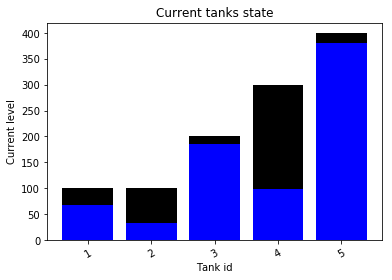

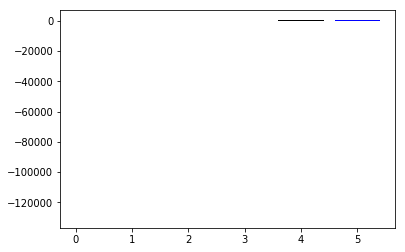

In [13]:
p = plt.plot([i for i in range(len(test_rewards_list))], test_rewards_list)
print(np.mean(test_rewards_list) )

plt.show()

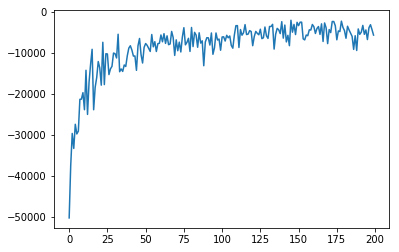

In [16]:
# Visualizing train simulation:

# train_anim = ut.create_system_animation(train_visualization_steps, train_iterations, train_freq)
# HTML(train_anim.to_html5_video())

episode = 200000
simulation_id = 11
discrewards_list = ut.load_obj("discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
p = plt.plot([i for i in range(len(discrewards_list))], discrewards_list)
#print(discrewards_list)

plt.show()

In [17]:
   # simulation_id = 4
    #train_iterations = 2*10**6
    #test_toy_system = ut.load_obj("system-sim"+ f"{simulation_id}")    
    #Q = ut.load_obj("Q-dict-sim" + f"{simulation_id}" + "-" + f"{train_iterations}")

len(list(Q))

24693